Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.


# LAB9

Write a local-search algorithm (eg. an EA) able to solve the _Problem_ instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

- Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
- Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

- Reviews will be assigned on Monday, December 4
- You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)


In [2116]:
from random import choices, choice, random, randint, sample
from copy import copy

import lab9_lib

In [2117]:
GENOME_LENGTH = 50

In [2118]:
POPULATION_SIZE = 100
OFFSPRING_SIZE = 20
MUTATION_PROBABILITY = 0.15
TOURNAMENT_SIZE = 2
PROBLEM_SIZE = 1

In [2119]:
def tournament_selection(population):
    return max(
        [choice(population) for _ in range(TOURNAMENT_SIZE)], key=lambda i: fitness(i)
    )


def one_cut_xover(ind1, ind2):
    cut_point = randint(0, GENOME_LENGTH - 1)
    offspring = ind1[:cut_point] + ind2[cut_point:]
    return offspring


def two_point_xover(ind1, ind2):
    pos1 = randint(0, GENOME_LENGTH - 1)
    pos2 = randint(pos1, GENOME_LENGTH - 1)
    offspring = ind1[:pos1] + ind2[pos1:pos2] + ind1[pos2:]
    return offspring


def flip_random_bit(ind):
    offspring = copy(ind)
    pos = randint(0, GENOME_LENGTH - 1)
    offspring[pos] = int(not offspring[pos])
    return offspring


def flip_2_random_bits(ind):
    offspring = copy(ind)
    pos1, pos2 = tuple(choices(range(0, GENOME_LENGTH), k=2))
    offspring[pos1] = int(not ind[pos1])
    offspring[pos2] = int(not ind[pos2])
    return offspring


def swap_two_bits(ind):
    offspring = copy(ind)
    pos1, pos2 = tuple(choices(range(0, GENOME_LENGTH), k=2))
    offspring[pos1] = ind[pos2]
    offspring[pos2] = ind[pos1]
    return offspring


def scramble(ind):
    offspring = copy(ind)
    pos1 = randint(0, GENOME_LENGTH - 1)
    pos2 = randint(pos1, GENOME_LENGTH - 1)
    to_scramble = offspring[pos1:pos2]
    permutation = sample(to_scramble, len(to_scramble))
    offspring[pos1:pos2] = permutation
    return offspring


def inversion(ind):
    offspring = copy(ind)
    pos1 = randint(0, GENOME_LENGTH - 1)
    pos2 = randint(pos1, GENOME_LENGTH - 1)
    offspring[pos1:pos2] = list(reversed(ind[pos1:pos2]))
    return offspring

0.44 [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
0.44 [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
0.44 [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
0.48 [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]
0.48 [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]
0.48 [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]
0.48 [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0

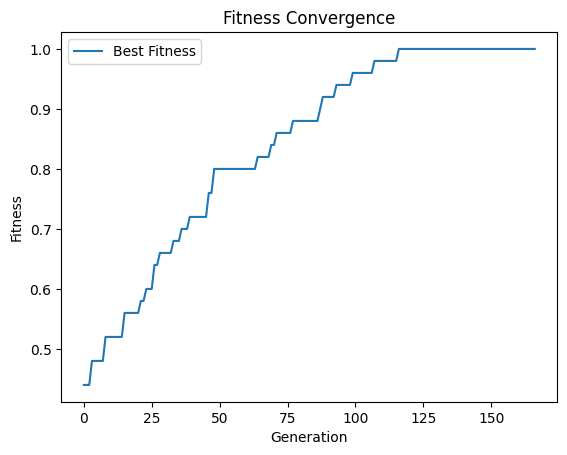

32762


In [2120]:
import matplotlib.pyplot as plt

population = [choices([0, 1], k=GENOME_LENGTH)] * POPULATION_SIZE
fitness = lab9_lib.make_problem(PROBLEM_SIZE)


def evolution(
    population,
    parent_selection,
    crossover,
    mutation,
    generations,
    max_no_improvement,
):
    best_fitness = float("-inf")
    consecutive_no_improvement = 0
    fitness_history = []

    for generation in range(generations):
        offspring = list()

        for counter in range(OFFSPRING_SIZE):
            if random() < MUTATION_PROBABILITY:
                p = parent_selection(population)
                o = mutation(p)
            else:
                p1 = parent_selection(population)
                p2 = parent_selection(population)
                o = crossover(p1, p2)
            offspring.append(o)

        combined_population = population + offspring

        combined_population.sort(key=lambda i: fitness(i), reverse=True)
        population = combined_population[:POPULATION_SIZE]

        if fitness(population[0]) > best_fitness:
            best_fitness = fitness(population[0])
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        fitness_history.append(best_fitness)

        if consecutive_no_improvement >= max_no_improvement:
            print(f"Converged at generation {generation}")
            break

        print(fitness(population[0]), population[0], flush=True)

    plt.plot(range(0, generation + 1), fitness_history, label="Best Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness Convergence")
    plt.legend()
    plt.show()


evolution(population, tournament_selection, one_cut_xover, flip_2_random_bits, 200, 50)
print(fitness.calls)